## 분석하면서 생각한 핵심포인트
  - train[family_size] > 7 인 이상치 제거
  - 중복 데이터 처리를 위해 개인정보를 모두 합쳐 ID 변수 생성
  (단, 같은 사용자가 여러번 카드를 발급할 수 있다는 가정 하에 begin_month는 개인정보에서 제외함)
  - 개인의 특성이 될 만한 파생변수 추가 
  - Catboost 모델 사용

### 패키지 설치

## 라이브러리 구성

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool


## 데이터 불러오기

In [169]:
train = pd.read_csv("../data/open/train.csv")
test = pd.read_csv("../data/open/test.csv")

## 데이터 전처리

### 1. 결측치 처리

In [170]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

- 직업의 결측치를 freelancer와 inoccupation으로 대체
- freelancer = 노동시간이 있는경우
- inoccupation = 노동시간이 없는경우

In [171]:
train['occyp_type'] = np.where((train['occyp_type']=='NaN')&(train['DAYS_EMPLOYED']<0),'freelancer',train['occyp_type'])
train['occyp_type']=train['occyp_type'].replace('NaN','inoccupation')
test['occyp_type'] = np.where((test['occyp_type']=='NaN')&(test['DAYS_EMPLOYED']<0),'freelancer',test['occyp_type'])
test['occyp_type']=test['occyp_type'].replace('NaN','inoccupation')

- single이고 결혼하지 않았는데 아이가 있는경우 widow로 대체

In [172]:
train['family_type']=np.where((train['family_type']=='Single / not married')&(train['child_num']!=0),'Widow',train['family_type'])
test['family_type']=np.where((test['family_type']=='Single / not married')&(test['child_num']!=0),'Widow',test['family_type'])

### 2. 이상치 처리
-  train['family_size'] > 7 인 데이터 제거

In [173]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

## Feature Engineering

### 1. 의미없는 변수 제거
- index 제거
- FLAG_MOBIL 삭제:모든 값이 1로 동일 

In [174]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

### 2. DAYS_EMPLOYED 
- 양수인 데이터는 현재 무직자로 판단, 0 처리

In [175]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

### 3. DAYS_BIRTH, begin_month, DAYS_EMPLOYED
-  음수값 -> 양수 변환

In [176]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### 4. 파생변수
 - numeric 변수는 최대한 다양한 특징을 보일 수 있도록 생성
 - category 변수는 여러가지를 조합해 보았지만 전체 변수를 합친 ID 하나만 만들었을때 가장 logloss가 낮았음
 - ref) rollcake님 글 https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent

In [177]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,freelancer,2.0,6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,0,0,0,Core staff,4.0,2.0,1.0
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,2475,0,0,0,freelancer,2.0,47.0,2.0
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,0,0,0,Core staff,2.0,25.0,2.0
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,107,0,0,0,Laborers,1.0,59.0,2.0


In [178]:
train.shape

(26451, 18)

In [179]:
train[train.duplicated()==1].shape # 중복 데이터 1634개

(1634, 18)

In [127]:
train.iloc[:,:-2][train.iloc[:,:-2].duplicated()==1].shape #begin_month / credit을 제외한 중복데이터

(17695, 16)

In [128]:
train.iloc[:,:-1][train.iloc[:,:-1].duplicated()==1].shape #credit을 제외한 중복데이터

(2353, 17)

In [1274]:
2353 - 1634 # credit만 다른 데이터 719개

719

In [1275]:
train_ = train.copy()
test_ = test.copy()
# train = train_
# test = test_

In [1276]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,freelancer,2.0,6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,0,0,0,Core staff,4.0,2.0,1.0
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,2475,0,0,0,freelancer,2.0,47.0,2.0
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,0,0,0,Core staff,2.0,25.0,2.0
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,107,0,0,0,Laborers,1.0,59.0,2.0


In [51]:
train.skew()

child_num        1.720807
income_total     2.659126
DAYS_BIRTH       0.185950
DAYS_EMPLOYED    1.763874
work_phone       1.319382
phone            0.903289
email            2.837989
family_size      0.875964
begin_month      0.290062
credit          -1.124043
dtype: float64

In [180]:
for df in [train,test]:
    # before_EMPLOYED: 고용되기 전까지의 일수
    # df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    # df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    # df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    # df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
    # df['Age'] = df['DAYS_BIRTH'] // 365
    # df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    # df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    # #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
    # df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    # df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    # df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    # #ability: 소득/(살아온 일수+ 근무일수)
    # df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    # #income_mean: 소득/ 가족 수
    # df['income_mean'] = df['income_total'] / df['family_size']

    
    #ID 생성: 각 컬럼의 값들을 더해서 고유한 사람을 파악(*한 사람이 여러 개 카드를 만들 가능성을 고려해 begin_month는 제외함)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['family_size'].astype(str) + '_' +df['email'].astype(str)+'_'+\
    df['car'].astype(str)+ '_' +df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)
    


In [64]:
# for df in [test,train]:
#     df['dup']=np.where(df['ID'].duplicated()==True,'egtikeul','unique')
#     df['ID']=df['ID']+'_'+df['dup']

In [65]:
# for df in [test,train]:
#     df.drop('dup',axis=1,inplace=True)

## Scaling, Encoding

In [66]:
train.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'phone', 'email', 'occyp_type', 'family_size',
       'begin_month', 'credit', 'ID'],
      dtype='object')

### 1. Numeric, Category 컬럼 분류

In [67]:
# cols = ['child_num', 'email','gender','reality','work_phone','car','phone','family_size']
# train.drop(cols, axis=1, inplace=True)
# test.drop(cols, axis=1, inplace=True)

In [181]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  9
Number of Categorical features:  9


In [68]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

In [69]:
numerical_feats

['child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month']

### 2. Log Scale
- income_total

In [1126]:
plt.figure(figsize=(14,7))
sns.barplot(data=train,x='credit',y='begin_month',hue='dup',ci=None)

ValueError: Could not interpret input 'dup'

<Figure size 1008x504 with 0 Axes>

In [1127]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID1
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,4709,0,0,0,freelancer,2.0,6.0,1.0,0_202500.0_13899_4709_0_0_2.0_0_N_Commercial a...
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,1540,0,0,1,Laborers,3.0,5.0,1.0,1_247500.0_11380_1540_0_0_3.0_1_Y_Commercial a...
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,4434,0,1,0,Managers,2.0,22.0,2.0,0_450000.0_19087_4434_0_1_2.0_0_Y_Working_High...
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,2092,0,1,0,Sales staff,2.0,37.0,0.0,0_202500.0_15088_2092_0_1_2.0_0_Y_Commercial a...
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,2105,0,0,0,Managers,2.0,26.0,2.0,0_157500.0_15037_2105_0_0_2.0_0_Y_State servan...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,1984,0,0,0,Core staff,4.0,2.0,1.0,2_225000.0_12079_1984_0_0_4.0_0_N_State servan...
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,2475,0,0,0,freelancer,2.0,47.0,2.0,1_180000.0_15291_2475_0_0_2.0_0_Y_Working_High...
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,2015,0,0,0,Core staff,2.0,25.0,2.0,0_292500.0_10082_2015_0_0_2.0_0_N_Working_Seco...
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,10145,107,0,0,0,Laborers,1.0,59.0,2.0,0_171000.0_10145_107_0_0_1.0_0_Y_Working_Incom...


In [94]:
test.skew()

child_num        1.762686
income_total     0.103096
DAYS_BIRTH       0.179701
DAYS_EMPLOYED    1.744492
work_phone       1.299556
phone            0.892332
email            2.962852
family_size      0.924311
begin_month      0.276876
dtype: float64

### 3. OrdinalEncoder 
- 카테고리 변수는 ordinal_encoder 변환 
- ID는 변환 후 정수 처리



In [182]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats])
test[categorical_feats] = encoder.transform(test[categorical_feats])

In [108]:
for df in [test,train]:
    df['income_total']=np.log1p(df['income_total'])

### 6. Count 컬럼 생성

In [1130]:
df_ID = train['ID'].value_counts().reset_index()

KeyError: 'ID'

In [1131]:
df_ID.rename({'index':'ID', 'ID':'count'}, axis =1 , inplace=True)

In [1132]:
df_ID_ = test['ID'].value_counts().reset_index()

KeyError: 'ID'

In [677]:
df_ID_.rename({'index':'ID', 'ID':'count'}, axis =1 , inplace=True)

In [678]:
train['count'] = 1
test['count'] = 1

In [679]:
func = lambda x: df_ID['count'].values[df_ID['count'][df_ID['ID'] == x].index][0]
train['count'] = train['ID'].apply(func)

KeyboardInterrupt: 

In [273]:
func = lambda x: df_ID_['count'].values[df_ID_['count'][df_ID_['ID'] == x].index][0]
test['count'] = test['ID'].apply(func)

In [274]:
# train = train[train['count'] < 30]
# train.reset_index(inplace=True, drop=True)

In [183]:
cols = ['gender',
 'car',
 'reality',
'child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size']
train.drop(cols,axis=1,inplace=True)
test.drop(cols,axis=1,inplace=True)

### 4. 클러스터링 구성
- 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

In [175]:
# kmeans_train = train.drop(['credit'], axis=1)
# kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
# train['cluster'] = kmeans.predict(kmeans_train)
# test['cluster'] = kmeans.predict(test)

### 5. StandardScaler
- 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [109]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
numerical_feats.remove('income_total')
#numerical_feats.remove('begin_month')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

### 5. 파생변수와 다중공선을 보이는 컬럼 삭제

## Modeling - catboost
 - fold 수를 5부터 17까지 돌려보고 최적 fold 15로 판단 후 선택
 - parameter를 default로 두는 것이 logloss가 가장 낮았음
 - ref) Catboost Documentation - https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html

In [184]:
n_est = 1000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [167]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26451 entries, 0 to 26450
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   income_type  26451 non-null  int32  
 1   edu_type     26451 non-null  int32  
 2   family_type  26451 non-null  int32  
 3   house_type   26451 non-null  int32  
 4   occyp_type   26451 non-null  int32  
 5   begin_month  26451 non-null  float64
 6   credit       26451 non-null  float64
 7   ID           26451 non-null  int32  
dtypes: float64(2), int32(6)
memory usage: 1.0 MB


In [188]:
for df in [train,test]:
    df['begin_month']=df['begin_month'].astype(int)
    df['ID']=df['ID'].astype(str)

In [189]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier(n_estimators=n_est)
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=200, verbose=100,)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115127
0:	learn: 1.0348476	test: 1.0337453	best: 1.0337453 (0)	total: 44.5ms	remaining: 44.5s
100:	learn: 0.7041860	test: 0.6389652	best: 0.6388063 (89)	total: 2.4s	remaining: 21.4s
200:	learn: 0.6869672	test: 0.6409571	best: 0.6388063 (89)	total: 4.92s	remaining: 19.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6388063338
bestIteration = 89

Shrink model to first 90 iterations.
CV Log Loss Score: 0.638806

----------------- Fold 1 -----------------

Learning rate set to 0.115127
0:	learn: 1.0347418	test: 1.0345188	best: 1.0345188 (0)	total: 69.4ms	remaining: 1m 9s
100:	learn: 0.7014469	test: 0.6699480	best: 0.6699099 (95)	total: 2.42s	remaining: 21.5s
200:	learn: 0.6842261	test: 0.6731896	best: 0.6698992 (115)	total: 5.03s	remaining: 20s
300:	learn: 0.6707631	test: 0.6765030	best: 0.6698992 (115)	total: 7.61s	remaining: 17.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 

200:	learn: 0.6850923	test: 0.6701023	best: 0.6689068 (117)	total: 5.06s	remaining: 20.1s
300:	learn: 0.6711953	test: 0.6726682	best: 0.6689068 (117)	total: 7.63s	remaining: 17.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6689068005
bestIteration = 117

Shrink model to first 118 iterations.
CV Log Loss Score: 0.668907
	Log Loss: 0.664499


## Feautre Importance
 - ID의 중요도가 상당히 높게 나오는 것을 볼 수 있었음
 - plot_feature_importance 함수
    - ref) https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

In [190]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

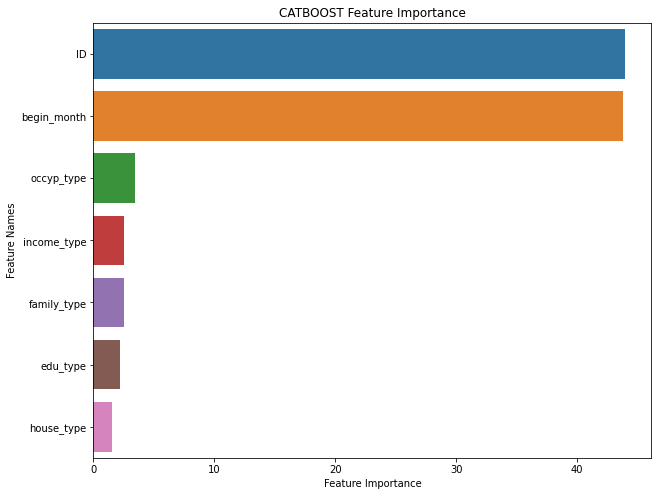

In [191]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## Submission

### submission 파일 불러오기

In [40]:
# sub = pd.read_csv(path + 'sample_submission.csv')
sub = pd.read_csv("../data/open/sample_submission.csv")

### submission 파일 저장

In [41]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.103751,0.164660,0.731589
1,26458,0.277419,0.307384,0.415197
2,26459,0.042529,0.066389,0.891083
3,26460,0.051640,0.077212,0.871148
4,26461,0.056222,0.261197,0.682581
...,...,...,...,...
9995,36452,0.056496,0.253904,0.689600
9996,36453,0.338909,0.159009,0.502082
9997,36454,0.042784,0.132665,0.824551
9998,36455,0.130567,0.341100,0.528334


In [42]:
sub.to_csv('zzzz.csv', index=False)